In [1]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import cv2 as cv
import os
import glob
import time
import pandas as pd
import random
#from scipy.signal import butter, lfilter
#from scipy import signal
#from scipy.signal import find_peaks, resample_poly

# from joblib import Parallel, delayed
# import multiprocessing
# from ipywidgets import interactive, widgets
# from skimage.registration import phase_cross_correlation
# from skimage.registration._phase_cross_correlation import _upsampled_dft
# from scipy.ndimage import fourier_shift
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image
import PyCBD.pipelines
from PyCBD.pipelines import CBDPipeline
from PyCBD.checkerboard_detection.checkerboard_detector import CheckerboardDetector
import matplotlib.transforms as mtransforms


##  Checkerboard Corner Detection

In [22]:
im_dir1 = r"D:\FST_972_FF_Sphere\Calibration\2100K_Checkerboard_FF"
im_dir2 = r"D:\FST_972_FF_Sphere\Calibration\480K_CheckerBoard_ff_C001H001S0001"
files1  = sorted(glob.glob(os.path.join(im_dir1, "*.tif"))) 
files2  = sorted(glob.glob(os.path.join(im_dir2, "*.tif"))) 
#glob.glob lists all files that start with im_dir and end with tif
#output_dir1= r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Masked_images"
#os.mkdir(output_dir1)
#output_dir2=r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Masked_images"
#os.mkdir(output_dir2)

### Camera 2100K

In [ ]:
# # Define input and output directories
# input_folder = r"D:\FST_972_FF_Sphere\Calibration\2100K_Checkerboard_FF"
input_folder=im_dir2
output_folder = r"D:\FST_972_FF_Sphere\Calibration\480K_Processed_Images"
# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize detection pipeline
# detection_pipeline = CBDPipeline(expand=True, predict=True)
detection_pipeline = CBDPipeline()

# Arrays to store detected points
detected_data = []  # Store (image_name, board_uv, board_xy)
i=0

# Process each image in the folder
for file in sorted(os.listdir(input_folder)):
    if file.endswith(".tif"):  # Process only TIFF images
        fname = os.path.join(input_folder, file)
        img = Image.open(fname)
        image = np.array(img)
        
        # Convert 16-bit to 8-bit if needed
        if image.dtype == np.uint16:
            image = (image / 16).astype(np.uint8)
        
        # # Detect checkerboard
        # n_rows = 7
        # n_cols = 2
        # result, board_uv, board_xy = detection_pipeline.detect_checkerboard(image,(n_rows, n_cols))
        result, board_uv, board_xy = detection_pipeline.detect_checkerboard(image)
        
        if result:
            detected_data.append((i, board_uv, board_xy, result))
            # Plot result
            fig, ax = plt.subplots()
            ax.imshow(image, cmap='gray')
            ax.plot(board_uv[:, 0], board_uv[:, 1], 'r-o', markeredgecolor='k')
            
            # Add annotations
            trans_offset = mtransforms.offset_copy(ax.transData, fig=fig, x=-0.4, y=-0.20, units='inches')
            ax.text(board_uv[0, 0], board_uv[0, 1], f'({int(board_xy[0, 0])}, {int(board_xy[0, 1])})',
                    color="red", transform=trans_offset)
            trans_offset = mtransforms.offset_copy(ax.transData, fig=fig, x=0.05, y=0.05, units='inches')
            ax.text(board_uv[-1, 0], board_uv[-1, 1], f'({int(board_xy[-1, 0])}, {int(board_xy[-1, 1])})',
                    color="red", transform=trans_offset)
            plt.title(f"Detection result: {file}")
            plt.axis('off')
            # Save the plot
            output_fname = os.path.join(output_folder, f"Processed_{file}")
            #plt.savefig(output_fname, bbox_inches='tight', dpi=300)
            plt.close(fig)
        i+=1
# Save detected data
#np.save(os.path.join(r"D:\FST_972_FF_Sphere\Calibration", "detected_checkerboard_data_480K.npy"), detected_data)
# print("Processing completed. All images are saved in", output_folder)

### Camera 480K

In [ ]:

# Ensure input and output directories exist
input_folder = im_dir2
output_folder = r"D:\FST_972_FF_Sphere\Calibration\480K_Processed_Images"
os.makedirs(output_folder, exist_ok=True)  # Create output folder if not exists

# Initialize detection pipeline
detection_pipeline = CBDPipeline()

# Array to store detected points
detected_data = []  
i = 0

# Process each image in the folder
for file in sorted(os.listdir(input_folder)):
    if file.endswith(".tif"):  # Process only TIFF images
        fname = os.path.join(input_folder, file)
        img = Image.open(fname)
        image = np.array(img)

        # Convert 16-bit to 8-bit if needed
        if image.dtype == np.uint16:
            image = (image / 16).astype(np.uint8)

        # Detect checkerboard
        result, board_uv, board_xy = detection_pipeline.detect_checkerboard(image)

        if result:
            # Validate board_uv (remove NaN, inf, and extreme values)
            valid_mask = np.all(np.isfinite(board_uv), axis=1) & (board_uv[:, 0] > 0) & (board_uv[:, 1] > 0)
            board_uv = board_uv[valid_mask]
            board_xy = board_xy[valid_mask] if board_xy is not None else None

            # If no valid points remain, skip plotting
            if board_uv.shape[0] == 0:
                print(f"Warning: No valid points left after filtering in {file}, skipping plot.")
                continue  

            detected_data.append((i, board_uv, board_xy, result))

            # Plot the detected checkerboard
            fig, ax = plt.subplots()
            ax.imshow(image, cmap='gray')
            ax.plot(board_uv[:, 0], board_uv[:, 1], 'r-o', markeredgecolor='k')

            # Add annotations safely (only if at least 2 points exist)
            try:
                if board_uv.shape[0] > 1:
                    ax.text(board_uv[0, 0], board_uv[0, 1], 
                            f'({int(board_xy[0, 0])}, {int(board_xy[0, 1])})', 
                            color="red", transform=ax.transData)
                    ax.text(board_uv[-1, 0], board_uv[-1, 1], 
                            f'({int(board_xy[-1, 0])}, {int(board_xy[-1, 1])})', 
                            color="red", transform=ax.transData)
            except Exception as e:
                print(f"Text placement failed for {file}: {e}")

            plt.title(f"Detection result: {file}")
            plt.axis('off')

            # Ensure valid output file name
            file_safe = file.replace(" ", "_").replace(":", "_")
            output_fname = os.path.join(output_folder, f"Processed_{file_safe}")

            # Save the figure safely
            try:
                #plt.savefig(output_fname, dpi=150)  # Avoid bbox_inches='tight'
                plt.close(fig)
            except Exception as e:
                print(f"Error saving figure {file}: {e}")
        
        i += 1

# Save detected data to a file
output_data_file = os.path.join(output_folder, "detected_checkerboard_data_480K.npy")
#np.save(output_data_file, detected_data)

print("Processing completed. All images are saved in", output_folder)


## Select images with 8*3 Corners detected for both cameras 

In [ ]:
# # # Load detected checkerboard data
# data = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_480K.npy", allow_pickle=True)
# data = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_2100K.npy", allow_pickle=True)

In [ ]:
# # # Load detected checkerboard data
# data = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_2100K.npy", allow_pickle=True)
# # Load CSV file with good image numbers
# cal_images2100k_df = pd.read_csv(r"D:\FST_972_FF_Sphere\Calibration\Calibration_images_2100K.csv")
# cal_images2100k = set(cal_images2100k_df['Image_Number'].tolist())
# output=r"D:\FST_972_FF_Sphere\Calibration\detected_8x3_checkerboard_data_2100K.npy"


# Load detected checkerboard data
data = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_480K.npy", allow_pickle=True)
# Load CSV file with good image numbers
cal_images480k_df = pd.read_csv(r"D:\FST_972_FF_Sphere\Calibration\Calibration_images_480k.csv")
cal_images480k = set(cal_images480k_df['Image_Number'].tolist())
output=r"D:\FST_972_FF_Sphere\Calibration\detected_8x3_checkerboard_data_480K.npy"

### Get Image points and object points for board size of 8*3 from csv with filtered checkerboard images 

In [ ]:
# Prepare object points (assuming a known checkerboard size)
board_size = (8, 3)  # Update based on how many points were detected in your checkerboard
square_size = 25  # In mm or other real-world units

objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1, 2) * square_size

# Store all good detections
detected_data=[] #all points
obj_points = []  # 3D points
img_points = []  # 2D points

# for i in cal_images2100k:
for i in cal_images480k:
    img_n=i
    board_uv=data[i-1][1]
    board_xy=data[i-1][2]
    if len(board_uv) == board_size[0] * board_size[1]:  # Ensure full board detection
        detected_data.append((i, board_uv, board_xy))
        obj_points.append(objp)
        img_points.append(board_uv.astype(np.float32))

#np.save(output, detected_data)

 c:\Users\Abinayaa\anaconda3\envs\pycbd_env\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Individual Camera Calibration

In [ ]:
# Load detected checkerboard data
data = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_2100K.npy", allow_pickle=True)
# data = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_480K.npy", allow_pickle=True)

##images chosen for 2000K
images = [3830,61,3721,3157,1773,1686,1557,3587,621,3472,1124,264,2383,3381,775,1629,3302,1080,1445]

##images chosen for 480K
# images = [41,326,410, 524, 656,773,874, 1078,
        #   1198, 1258, 1445,1553,1625,1688,1769,1819, 1988, 
        #   2384,2447, 2544, 3030,3320,3847]


# images = [61, 177, 264, 314, 405, 525, 600, 621, 743,775, 857, 925, 1020,1080, 1124,
#            1185, 1268, 1340, 1445, 1557,1629, 1686, 1773,1861, 1940, 1994] #,
        #    2020, 2162, 2282, 2383, 2503, 2615, 2724, 2873, 2968,
        #     3038, 3117, 3157, 3250,3302, 3381, 3470,3472, 3566, 3587, 3654, 3721, 3825, 3830,3963 ]
# images = np.concatenate([np.arange(342,427),np.arange(430,525)])
# images = np.arange(430,525)
# images = np.arange(2073,2312)
# images = np.arange(2523,2600)
# Prepare object points (assuming a known checkerboard size)
board_size = (8, 3)  # Update based on how many points were detected in your checkerboard
square_size = 25   # In mm or other real-world units

# Create object points in the correct column-major order
objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)

# Generate points where Y varies first, then X (column-major order)
objp[:, 0] = np.repeat(np.arange(0, board_size[0] * square_size, square_size), board_size[1])
objp[:, 1] = np.tile(np.arange(0, board_size[1] * square_size, square_size), board_size[0])


# Store all good detections
detected_data=[] #all points
obj_points = []  # 3D points
img_points = []  # 2D points

for i in images:
    img_n=i
    board_uv=data[i-1][1]
    board_xy=data[i-1][2]
    if len(board_uv) == board_size[0] * board_size[1]:  # Ensure full board detection
        detected_data.append((i, board_uv, board_xy))
        obj_points.append(objp)
        img_points.append(board_uv.astype(np.float32))

### Get intrinsic camera parameters

In [ ]:
# Specify image resolution 
w, h = 1024, 840

# sw = 20.48

# # Given expected focal length in mm
# expected_focal_length_mm = 60.0  # As per lens specification
# sf = 0.217

# # Compute expected focal length in pixels
# expected_focal_length_px = (expected_focal_length_mm / sf) 

# # Define the expected camera matrix
# camera_matrix = np.array([[expected_focal_length_px, 0, w / 2],
#                           [0, expected_focal_length_px, w / 2],
#                           [0, 0, 1]], dtype=np.float32)

# Camera calibration
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, (w, h), None, None)
# ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, (w, h), camera_matrix, None, flags=cv.CALIB_USE_INTRINSIC_GUESS)

# Compute Reprojection Error
print("Calibration Successful")
print("Error in projection:\n", ret)

total_error = 0
total_points = 0

for i in range(len(obj_points)):
    img_points_proj, _ = cv.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
    
    # Flatten img_points_proj to match img_points[i]
    img_points_proj = img_points_proj.reshape(-1, 2)
    
    # Compute per-image RMSE
    error = cv.norm(img_points[i], img_points_proj, cv.NORM_L2) / len(img_points_proj)
    
    # Accumulate squared errors
    total_error += error ** 2
    total_points += len(img_points_proj)

# Compute Final RMSE
rmse = np.sqrt(total_error / total_points)
print(f"Reprojection RMSE: {rmse:.4f} pixels")


print("Camera Matrix:\n", camera_matrix)
print("Distortion Coefficients:\n", dist_coeffs)
print("Rvecs:\n", rvecs)
print("Tvecs:\n", tvecs)




Calibration Successful
Error in projection:
 0.3748634233785197
Reprojection RMSE: 0.0156 pixels
Camera Matrix:
 [[3.17546161e+03 0.00000000e+00 4.95388772e+02]
 [0.00000000e+00 3.17565416e+03 3.62504241e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [[-3.37440435e-01  3.14439384e+01 -6.00618315e-03  2.35485025e-03
  -9.64400822e+02]]
Rvecs:
 (array([[3.03198487],
       [0.02931731],
       [0.08826881]]), array([[-3.11997414],
       [-0.04134161],
       [-0.05177397]]), array([[3.03517043],
       [0.02847368],
       [0.09152016]]), array([[3.07178325],
       [0.03449997],
       [0.07630884]]), array([[-2.88625332],
       [-0.03593689],
       [-0.66337808]]), array([[3.06353448],
       [0.01745148],
       [0.08416766]]), array([[2.87971636],
       [0.04073889],
       [0.82661634]]), array([[3.0292344 ],
       [0.02107973],
       [0.09863515]]), array([[3.07100322],
       [0.0682549 ],
       [0.01346755]]), array([[3.03117201],
       [0

In [ ]:
# Save calibration results
#np.savez(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz", 
 #       proj_err=ret, rmse=rmse, camera_matrix=camera_matrix, dist_coeffs=dist_coeffs, 
  #       rvecs=rvecs, tvecs=tvecs)

## Stereo Camera Calibration

In [2]:
camera_2100k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1=camera_2100k['camera_matrix']
D1=camera_2100k['dist_coeffs']
camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2=camera_480k['camera_matrix']
D2=camera_480k['dist_coeffs']

In [3]:
camera_2100k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
camera_2100k.files

['proj_err', 'rmse', 'camera_matrix', 'dist_coeffs', 'rvecs', 'tvecs']

In [4]:
camera_2100k['rmse']

array(0.01561931)

In [5]:
data1 = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_2100K.npy", allow_pickle=True)
data2 = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_480K.npy", allow_pickle=True)

#Choose image numbers that have good (8*3) corner detection in both cameras

images=[367, 372, 377, 382, 387, 392, 397, 402, 407, 412, 417, 422, 427, 1960, 2135, 2447, 2524, 2630, 2934]
# images=[367, 382, 397, 412, 427, 1960, 2135, 2447, 2524, 2630, 2934]
# images=np.arange(367,420)

board_size = (8, 3)  # Update based on how many points were detected in your checkerboard
square_size = 25   # In mm or other real-world units

# Create object points in the correct column-major order
objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)

# Generate points where Y varies first, then X (column-major order)
objp[:, 0] = np.repeat(np.arange(0, board_size[0] * square_size, square_size), board_size[1])
objp[:, 1] = np.tile(np.arange(0, board_size[1] * square_size, square_size), board_size[0])


# Store all good detections
detected_data=[] #all points
obj_points = []  # 3D points
img_points1 = []  # 2D points
img_points2 = []  # 2D points

for i in images:
    img_n=i
    board_uv1=data1[i-1][1]
    board_xy1=data1[i-1][2]
    board_uv2=data2[i-1][1]
    board_xy2=data2[i-1][2]
    if (len(board_uv1) == board_size[0] * board_size[1]) and (len(board_uv2) == board_size[0] * board_size[1]):  # Ensure full board detection
        detected_data.append((i, board_uv1, board_xy1, board_uv2, board_xy2))
        obj_points.append(objp)
        img_points1.append(board_uv1.astype(np.float32))
        img_points2.append(board_uv2.astype(np.float32))

In [6]:
# Image size of the calibration images
image_size = (1024, 840)

# Stereo calibration
ret, K1, D1, K2, D2, R, T, E, F = cv.stereoCalibrate(
    obj_points, img_points1, img_points2,
    K1, D1, K2, D2,
    image_size, 
    criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6),
    flags=cv.CALIB_FIX_INTRINSIC  # Keeps individual camera parameters fixed
)

# Output Parameters
print("proj_err:\n", ret)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (T):\n", T)
print("Essential Matrix (E):\n", E)
print("Fundamental Matrix (F):\n", F)


proj_err:
 0.6685738868550083
Rotation Matrix (R):
 [[ 9.86633149e-01  1.78328656e-03  1.62947382e-01]
 [ 6.74902790e-04  9.99886828e-01 -1.50291841e-02]
 [-1.62955742e-01  1.49382649e-02  9.86520286e-01]]
Translation Vector (T):
 [[-151.62322105]
 [  -1.2479339 ]
 [  15.10687675]]
Essential Matrix (E):
 [[   0.19316232  -15.12380904   -1.00406808]
 [  -9.80292915    2.29192773  152.04100938]
 [   1.12892202 -151.60383607    2.48212086]]
Fundamental Matrix (F):
 [[-1.28117675e-08  1.00304746e-06 -1.45788310e-04]
 [ 6.50312066e-07 -1.52033934e-07 -3.22953201e-02]
 [-5.17685068e-04  3.17182408e-02  1.00000000e+00]]


In [11]:
#Save calibration results
np.savez(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration_lowest.npz", 
        proj_err=ret, rotation_mat=R, transalation_vect=T, essential_mat=E, fundaemental_mat=F)

## Improve RMSE for Stereo Calibration, currently it is at 0.817, Needs to be less than 0.3

In [7]:
# Load the CSV files
file1 = r"D:\FST_972_FF_Sphere\Calibration\Calibration_images_480k.csv"
file2 = r"D:\FST_972_FF_Sphere\Calibration\Calibration_images_2100K.csv"

# Read the CSV files
csv1 = pd.read_csv(file1)
csv2 = pd.read_csv(file2)

# Assuming the image numbers are stored in a column named 'ImageNumber' in both files
common_images = pd.merge(csv1, csv2, on='Image_Number')

# Save the common image numbers to a new CSV file
output_file = r"D:\FST_972_FF_Sphere\Calibration\Calibration_Images_Common.csv"
common_images.to_csv(output_file, index=False)

# Displaying the first few rows of the common images
common_images.head()


,Image_Number
0,27
1,41
2,49
3,63
4,79


Load Camera Parameters

In [3]:
camera_2100k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1=camera_2100k['camera_matrix']
D1=camera_2100k['dist_coeffs']
camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2=camera_480k['camera_matrix']
D2=camera_480k['dist_coeffs']

In [4]:
data1 = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_2100K.npy", allow_pickle=True)
data2 = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_480K.npy", allow_pickle=True)

#Choose image numbers that have good (8*3) corner detection in both cameras
csv = r"D:\FST_972_FF_Sphere\Calibration\Calibration_Images_Common.csv"
common_data = pd.read_csv(csv)

image_data= common_data['Image_Number'].to_numpy()   
images =[2878, 1792, 821,549, 2327,2740, 2268, 2507, 278, 3576, 3599, 1189, 1219,1289,1262]
##images=[27,63,117,307, 314, 340, 342, 547, 549,674,792,1017, 1250, 1259, 1261, 1262, 1289,1445, 1500,1609,1871, 1888, 2010, 2064,2327, 2475, 2507, 2532, 2918,2968, 3015,3409, 3146 ]
#images=[2507, 1262,  549, 2327, 1289] 
print(images)

board_size = (8, 3)  # Update based on how many points were detected in your checkerboard
square_size = 25   # In mm or other real-world units

# Create object points in the correct column-major order
objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)

# Generate points where Y varies first, then X (column-major order)
objp[:, 0] = np.repeat(np.arange(0, board_size[0] * square_size, square_size), board_size[1])
objp[:, 1] = np.tile(np.arange(0, board_size[1] * square_size, square_size), board_size[0])


# Store all good detections
detected_data=[] #all points
obj_points = []  # 3D points
img_points1 = []  # 2D points
img_points2 = []  # 2D points

for i in images:
    img_n=i
    board_uv1=data1[i-1][1]
    board_xy1=data1[i-1][2]
    board_uv2=data2[i-1][1]
    board_xy2=data2[i-1][2]
    if (len(board_uv1) == board_size[0] * board_size[1]) and (len(board_uv2) == board_size[0] * board_size[1]):  # Ensure full board detection
        detected_data.append((i, board_uv1, board_xy1, board_uv2, board_xy2))
        obj_points.append(objp)
        img_points1.append(board_uv1.astype(np.float32))
        img_points2.append(board_uv2.astype(np.float32))

[2878, 1792, 821, 549, 2327, 2740, 2268, 2507, 278, 3576, 3599, 1189, 1219, 1289, 1262]


In [10]:
# Image size of the calibration images
image_size = (1024, 840)

# Stereo calibration
ret, K1, D1, K2, D2, R, T, E, F = cv.stereoCalibrate(
    obj_points, img_points1, img_points2,
    K1, D1, K2, D2,
    image_size, 
    criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6),
    flags=cv.CALIB_FIX_INTRINSIC  # Keeps individual camera parameters fixed
)

# Output Parameters
print("proj_err:\n", ret)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (T):\n", T)
print("Essential Matrix (E):\n", E)
print("Fundamental Matrix (F):\n", F)

proj_err:
 0.26944928836762233
Rotation Matrix (R):
 [[ 9.86109042e-01  1.80486129e-03  1.66089433e-01]
 [ 6.86695080e-04  9.99888117e-01 -1.49426459e-02]
 [-1.66097820e-01  1.48491310e-02  9.85997473e-01]]
Translation Vector (T):
 [[-153.97027345]
 [  -1.30007542]
 [  15.46303989]]
Essential Matrix (E):
 [[   0.2053213   -15.48061483   -1.05081235]
 [ -10.32588327    2.31423341  154.38254813]
 [   1.1762855  -153.95070028    2.51665207]]
Fundamental Matrix (F):
 [[-1.33077311e-08  1.00330248e-06 -1.40836030e-04]
 [ 6.69385868e-07 -1.50013434e-07 -3.20572628e-02]
 [-5.30125903e-04  3.14698432e-02  1.00000000e+00]]


In [5]:
# Image size of the calibration images
image_size = (1024, 840)

# Stereo calibration
ret, K1, D1, K2, D2, R, T, E, F = cv.stereoCalibrate(
    obj_points, img_points1, img_points2,
    K1, D1, K2, D2,
    image_size, 
    criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6),
    flags=cv.CALIB_FIX_INTRINSIC  # Keeps individual camera parameters fixed
)

# Output Parameters
print("proj_err:\n", ret)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (T):\n", T)
print("Essential Matrix (E):\n", E)
print("Fundamental Matrix (F):\n", F)

proj_err:
 0.31406873396621443
Rotation Matrix (R):
 [[ 9.86404028e-01  1.78280846e-03  1.64328681e-01]
 [ 6.65439796e-04  9.99889627e-01 -1.48422306e-02]
 [-1.64337005e-01  1.47497869e-02  9.86293969e-01]]
Translation Vector (T):
 [[-152.70271771]
 [  -1.37219475]
 [  15.14612009]]
Essential Matrix (E):
 [[   0.21542354  -15.16468794   -1.1285852 ]
 [ -10.15451338    2.27933517  153.09871142]
 [   1.25192397 -152.68341703    2.4919399 ]]
Fundamental Matrix (F):
 [[-1.41357801e-08  9.95024465e-07 -1.18535510e-04]
 [ 6.66446125e-07 -1.49584912e-07 -3.21828043e-02]
 [-5.47300068e-04  3.16049114e-02  1.00000000e+00]]


Found a valid set of images with reprojection error 0.26944928836762233:
[2507 1262  549 2327 1289]

Best error achieved: 0.37254075364701067
Image set leading to the lowest error:
[1871 2630 2714 2713 1445]


FINAL 10 IMAGES
proj_err:
 0.31406873396621443
images =[2878, 1792, 821,549, 2327,2740, 2268, 2507, 278, 3576, 3599, 1189, 1219,1289,1262]

In [6]:
#Save calibration results
np.savez(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration_best.npz", 
        proj_err=ret, rotation_mat=R, transalation_vect=T, essential_mat=E, fundaemental_mat=F)

In [137]:
# Load data from the two files

data1 = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_2100K.npy", allow_pickle=True)
data2 = np.load(r"D:\FST_972_FF_Sphere\Calibration\detected_checkerboard_data_480K.npy", allow_pickle=True)

# Load common image numbers
csv = r"D:\FST_972_FF_Sphere\Calibration\Calibration_Images_Common.csv"
common_data = pd.read_csv(csv)
image_data = common_data['Image_Number'].to_numpy()

# Load pre-calibrated camera parameters
camera_2100k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1 = camera_2100k['camera_matrix']
D1 = camera_2100k['dist_coeffs']

camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2 = camera_480k['camera_matrix']
D2 = camera_480k['dist_coeffs']

# Parameters
board_size = (8, 3)
square_size = 25
image_size = (1024, 840)

# Create object points
objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
objp[:, 0] = np.repeat(np.arange(0, board_size[0] * square_size, square_size), board_size[1])
objp[:, 1] = np.tile(np.arange(0, board_size[1] * square_size, square_size), board_size[0])

# Define the number of trials and desired error threshold
num_trials = 90000
desired_error = 0.314
successful_images = None
lowest_error = float('inf')
best_images = None

# Create a dataframe to store all errors and corresponding image sets
results_df = pd.DataFrame(columns=['Trial', 'Reprojection_Error', 'Image_Set'])


for trial in range(num_trials):
    images = np.random.choice(image_data, size=10, replace=False)

    obj_points = []
    img_points1 = []
    img_points2 = []

    for i in images:
        board_uv1 = data1[i - 1][1]
        board_uv2 = data2[i - 1][1]

        if len(board_uv1) == board_size[0] * board_size[1] and len(board_uv2) == board_size[0] * board_size[1]:
            obj_points.append(objp)
            img_points1.append(board_uv1.astype(np.float32))
            img_points2.append(board_uv2.astype(np.float32))

    # Only perform calibration if valid detections are collected
    if len(obj_points) == 5:
        # Stereo calibration with FIXED intrinsic parameters
        ret, K1, D1, K2, D2, R, T, E, F = cv.stereoCalibrate(
            obj_points, img_points1, img_points2,
            K1, D1, K2, D2,
            image_size,
            criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6),
            flags=cv.CALIB_FIX_INTRINSIC
        )

        # Save the result to the dataframe
        results_df = pd.concat([results_df, pd.DataFrame({'Trial': [trial], 'Reprojection_Error': [ret], 'Image_Set': [images]})], ignore_index=True)

        # Check if this set of images meets the criteria
        if ret <= desired_error:
            successful_images = images
            lowest_error = ret
            break  # Stop searching when a valid set is found

        # Track the best result found
        if ret < lowest_error:
            lowest_error = ret
            best_images = images


# Save all results to a CSV file
results_df.to_csv(r"D:\FST_972_FF_Sphere\Calibration\Reprojection_Errors_Trials.csv", index=False)

# Output results
if successful_images is not None:
    print(f"Found a valid set of images with reprojection error {lowest_error}:")
    print(successful_images)
else:
    print(f"No valid set found. Best error achieved: {lowest_error}")
    print("Image set leading to the lowest error:")
    print(best_images)


 C:\Users\Abinayaa\AppData\Local\Temp\ipykernel_8304\2648514776.py:69: FutureWarning:The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


No valid set found. Best error achieved: 0.4301766005120079
Image set leading to the lowest error:
[2475 2715 1381 2680  237 2798 2268  393  603 3576]


For 10 Image Pairs, 

Best proj_err:0.31406873396621443
images =[2878, 1792, 821,549, 2327,2740, 2268, 2507, 278, 3576, 3599, 1189, 1219,1289,1262]

Best error achieved: 0.3472420195772853
Image set leading to the lowest error:
[2878 1792  821 2740 2268  278 3576 3599 1189 1219]

## Verify Undistorted Image against original Image

In [22]:
#Load Camera Parameters
camera_2100k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1=camera_2100k['camera_matrix']
D1=camera_2100k['dist_coeffs']
camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2=camera_480k['camera_matrix']
D2=camera_480k['dist_coeffs']
camera_setup=np.load(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration_lowest.npz")
R=camera_setup['rotation_mat']
T=camera_setup['transalation_vect']

# Image size (should be the same for both cameras)
image_size = (1024, 840)  # Replace with actual image dimensions

# Stereo rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    K1, D1, K2, D2, image_size, R, T, 
    flags=cv.CALIB_ZERO_DISPARITY, alpha=1.0
)

# Compute undistortion and rectification transformation maps
map1_x, map1_y = cv.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv.CV_32FC1)
map2_x, map2_y = cv.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv.CV_32FC1)

## Pick the same image Number for both cameras

# Camera 1 image
fname1=r"D:\FST_972_FF_Sphere\Calibration\2100K_Checkerboard_FF\Partition 1000200.tif"
image1 = Image.open(fname1)
img1 = np.array(image1)
# Convert 16-bit to 8-bit if needed
if img1.dtype == np.uint16:
    img1 = (img1 / 16).astype(np.uint8)

#Camera 2 image
fname2=r"D:\FST_972_FF_Sphere\Calibration\480K_CheckerBoard_ff_C001H001S0001\480K_CheckerBoard_ff_C001H001S0001000200.tif"
image2 = Image.open(fname2)
img2 = np.array(image2)
# Convert 16-bit to 8-bit if needed
if img2.dtype == np.uint16:
    img2 = (img2 / 16).astype(np.uint8)


# Apply rectification and undistortion
undistorted_rectified_1 = cv.remap(img1, map1_x, map1_y, interpolation=cv.INTER_LINEAR)
undistorted_rectified_2 = cv.remap(img2, map2_x, map2_y, interpolation=cv.INTER_LINEAR)

# Crop images based on ROI (optional)
x, y, w, h = roi1
undistorted_rectified_1 = undistorted_rectified_1[y:y+h, x:x+w]

x, y, w, h = roi2
undistorted_rectified_2 = undistorted_rectified_2[y:y+h, x:x+w]


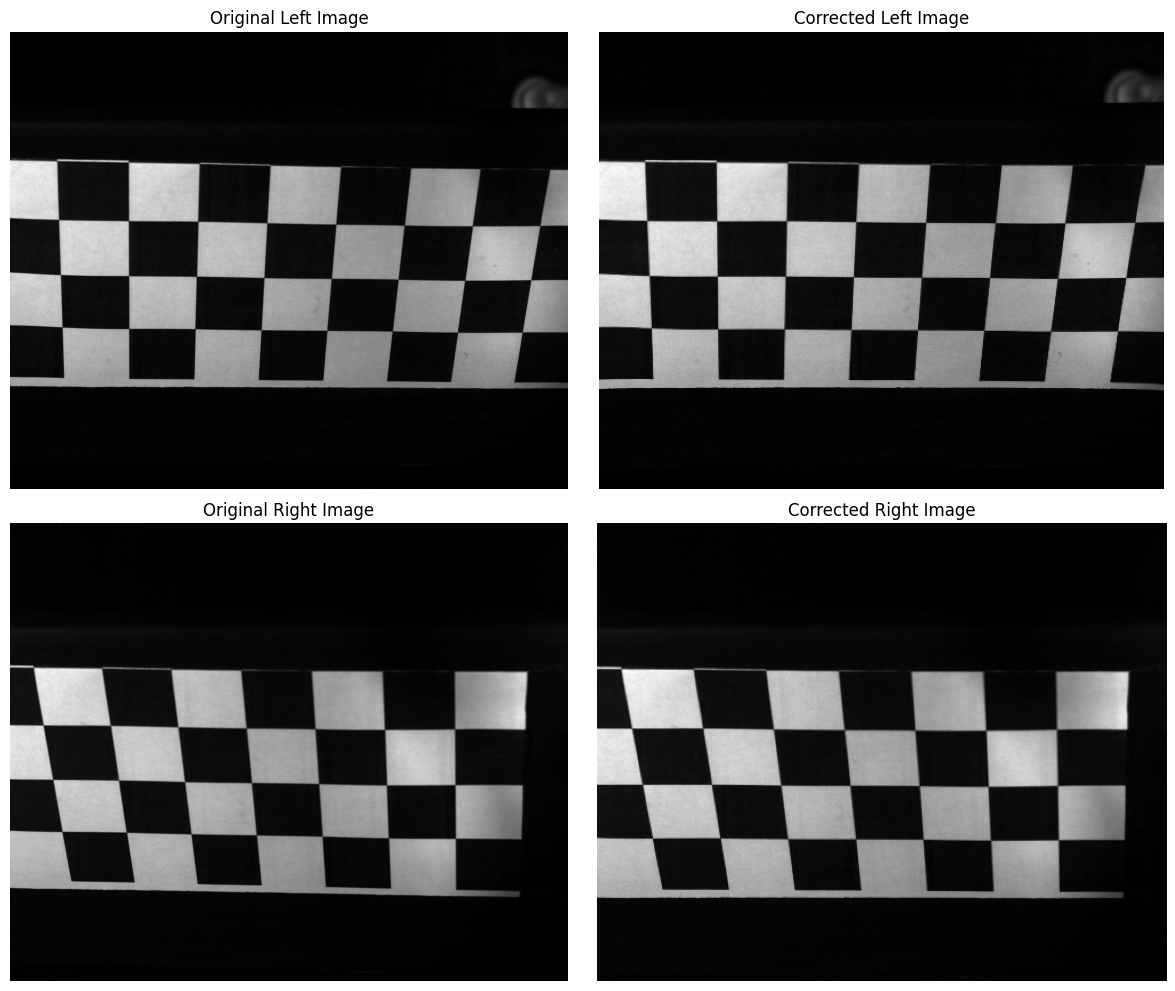

In [23]:
# Plot the images using Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Left Camera - Original vs. Corrected
axes[0, 0].imshow(img1, cmap='gray')
axes[0, 0].set_title("Original Left Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(undistorted_rectified_1, cmap='gray')
axes[0, 1].set_title("Corrected Left Image")
axes[0, 1].axis("off")

# Right Camera - Original vs. Corrected
axes[1, 0].imshow(img2, cmap='gray')
axes[1, 0].set_title("Original Right Image")
axes[1, 0].axis("off")

axes[1, 1].imshow(undistorted_rectified_2, cmap='gray')
axes[1, 1].set_title("Corrected Right Image")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


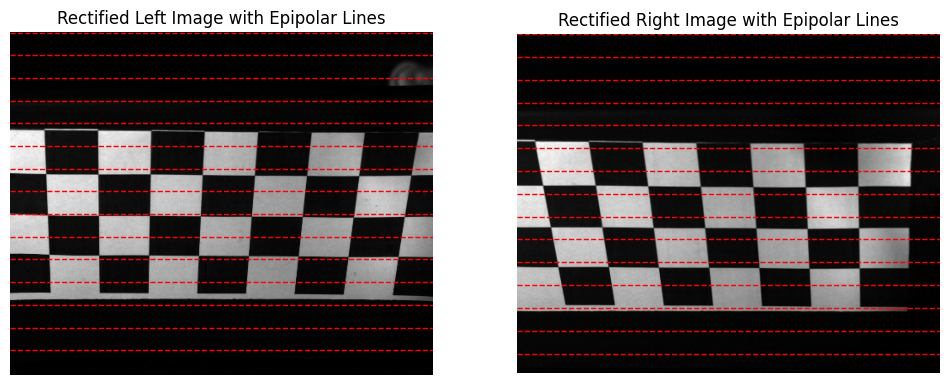

In [24]:
def draw_epipolar_lines(image1, image2):
    """ Draw horizontal epipolar lines to verify rectification """
    h, w = image1.shape[:2]
    num_lines = 15  # Number of lines to draw
    spacing = h // num_lines

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image1, cmap='gray')
    axes[1].imshow(image2, cmap='gray')

    for i in range(num_lines):
        y = i * spacing
        axes[0].axhline(y, color='red', linestyle='--', linewidth=1)
        axes[1].axhline(y, color='red', linestyle='--', linewidth=1)

    axes[0].set_title("Rectified Left Image with Epipolar Lines")
    axes[1].set_title("Rectified Right Image with Epipolar Lines")
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()

# Apply function to the corrected images
draw_epipolar_lines(undistorted_rectified_1, undistorted_rectified_2)


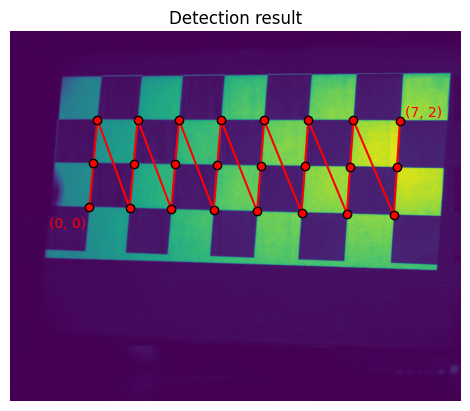

In [ ]:
# prepared_image = image
# checkerboard_detector = CheckerboardDetector()
# detected_board_uv, detected_board_xy, detected_corners_uv = checkerboard_detector.detect_checkerboard(prepared_image)

# #Plot result
# fig, ax = plt.subplots()
# ax.imshow(image)
# ax.plot(detected_board_uv[:, 0], detected_board_uv[:, 1], 'r-o', markeredgecolor='k')
# trans_offset = mtransforms.offset_copy(ax.transData, fig=fig, x=-0.4, y=-0.20, units='inches')
# ax.text(detected_board_uv[0, 0], detected_board_uv[0, 1], '(' + str(int(detected_board_xy[0, 0])) + ', ' + str(int(detected_board_xy[0, 1])) + ')',
#         color="red", transform=trans_offset)
# trans_offset = mtransforms.offset_copy(ax.transData, fig=fig, x=0.05, y=0.05, units='inches')
# ax.text(detected_board_uv[-1, 0], detected_board_uv[-1, 1], '(' + str(int(detected_board_xy[-1, 0])) + ', ' + str(int(detected_board_xy[-1, 1])) + ')',
#         color="red", transform=trans_offset)
# plt.title("Detection result")
# plt.axis('off')
# plt.show()